## SQLAlchemy and Flask Challenge - Surfs Up!
---
##### Submitted by : Sheetal Bongale | UT Data Analysis and Visualization | Feb 15, 2020
##### This Jupyter notebook contains scripts to perform and pull climate data from the hawaii.sqlite weather station table and climate analyis performed using Python and Pandas.

In [50]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

%load_ext lab_black

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results
* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the data and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
last_year = last_date - dt.timedelta(days=365)

# Also can be done by knowing that last date in db is 2017-08-23
# last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > last_year)
    .order_by(Measurement.date)
    .all()
)

In [22]:
# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(results, columns=["Date", "Precipitation"])
# Set the index to the date column and Sort by date
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"])
prcp_df = prcp_df.sort_values("Date").dropna().set_index("Date")

# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


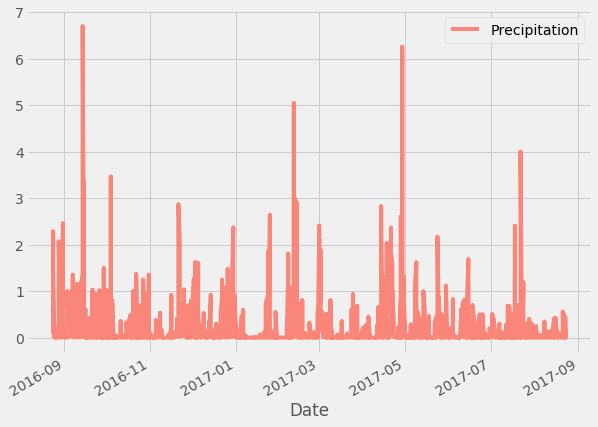

In [154]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color="salmon", alpha=0.95, figsize=(9, 7))

### Station Analysis
  
* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order.
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with `bins=12`.

In [40]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()

print(f"Number of Stations = {stations_count}")

Number of Stations = 9


In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = (
    session.query(Measurement.station, Station.name, func.count(Measurement.id))
    .filter(Measurement.station == Station.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)
print("Most active stations are:")
pprint(active_stations)

Most active stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [150]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
station_record = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == active_stations[0][0])
    .all()
)

print(
    f"Most active station is {active_stations[0][0]} - {active_stations[0][1]}. Following are its records:"
)
print(f"Lowest Temperature: {station_record[0][0]}F")
print(f"Highest Temperature: {station_record[0][1]}F")
print(f"Average Temperature: {station_record[0][2]}F")

Most active station is USC00519281 - WAIHEE 837.5, HI US. Following are its records:
Lowest Temperature: 54.0F
Highest Temperature: 85.0F
Average Temperature: 71.66378066378067F


Text(0, 0.5, 'Frequency')

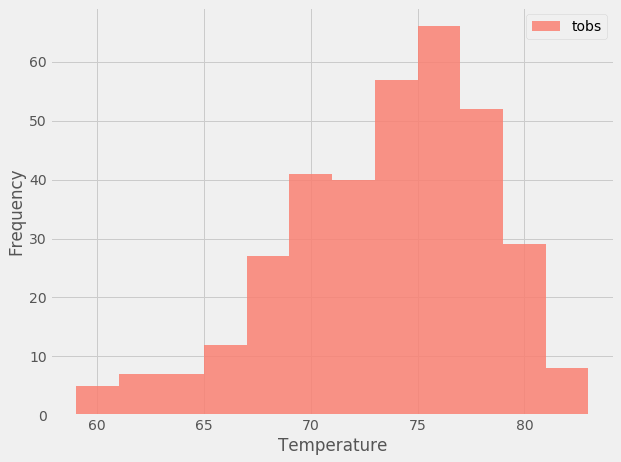

In [152]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > last_year)
    .filter(Measurement.station == active_stations[0][0])
    .order_by(Measurement.date)
    .all()
)

# Convert query object to dataframe
temp_df = pd.DataFrame(temp_results)
temp_df = temp_df.set_index("date").sort_index(ascending=True)


# Render the Histogram plot
temp_df.plot(kind="hist", color="salmon", bins=12, alpha=0.85, figsize=(9, 7))
plt.xlabel("Temperature")
plt.ylabel("Frequency")

### Temperature Analysis

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

In [114]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [135]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip_start = "2016-12-05"
trip_end = "2016-12-13"
trip_dates = "2017-12-05 to 2017-12-13"
prev_year = "2016-12-05 - \n 2016-12-13"

# prev_year_start = dt.date(2017, 1, 1) - dt.timedelta(days=365)
# prev_year_end = dt.date(2017, 1, 7) - dt.timedelta(days=365)

temps = calc_temps(trip_start, trip_end)
temp_min, temp_avg, temp_max = temps[0]

print("Here are your Trip's Weather Results!")
print(f" Min Temp : {temp_min}F")
print(f" Avg Temp : {temp_avg}F")
print(f" Max Temp : {temp_max}F")

Here are your Trip's Weather Results!
 Min Temp : 65.0F
 Avg Temp : 69.98275862068965F
 Max Temp : 78.0F


(0, 105)

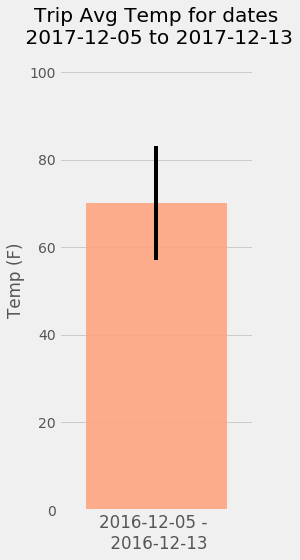

In [136]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = temp_max - temp_min
xpos = 1
height = temp_avg
plt.figure(figsize=(4, 8))
plt.bar(xpos, height, yerr=error, alpha=0.85, color="lightsalmon")
plt.title(f"Trip Avg Temp for dates\n {trip_dates}")
plt.xlabel(f"{prev_year}")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)

### Daily Rainfall Average.

* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.
* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.
* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [149]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(trip_start, trip_end),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rain_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.26
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.164
2,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.14500000000000002
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.1277777777777778
4,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.1166666666666667
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.10571428571428573
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.08666666666666667


## Optional Challenge Assignment


In [156]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [157]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_startdate = dt.date(2016, 12, 5)
trip_enddate = dt.date(2016, 12, 13)
# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_startdate, trip_enddate)
# Stip off the year and save a list of %m-%d strings
date_list = [d.strftime("%m-%d") for d in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(d)[0] for d in date_list]
daily_normal

[(64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0)]

In [158]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df

,tmin,tavg,tmax
Date,,,
2016-12-05,64.0,70.921569,78.0
2016-12-06,61.0,69.392157,78.0
2016-12-07,58.0,69.200000,79.0
2016-12-08,60.0,70.274510,83.0
2016-12-09,64.0,71.901961,80.0
2016-12-10,61.0,71.245283,78.0
2016-12-11,64.0,72.387755,78.0
2016-12-12,64.0,70.882353,79.0
2016-12-13,65.0,70.942308,80.0


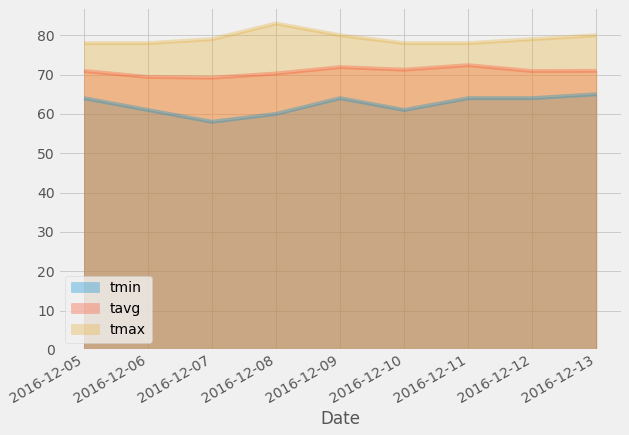

In [165]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 7))